# Gyroscope DDPG reward function testing (spinup library)

In [2]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

## Plot rewards

In [3]:
def read_progress(agent_path):
    
    # count lines
    file = open(agent_path+"/progress.txt", "r")
    count = len(file.readlines())
    data = np.empty([count-1, 19])
    file.seek(0)
    
    # read each line as a numpy array
    for row, x in enumerate(file):
        if row == 0:
            continue
        data[row-1] = np.array(x.split('\t')).astype(np.float)
    file.close()
    
    return data

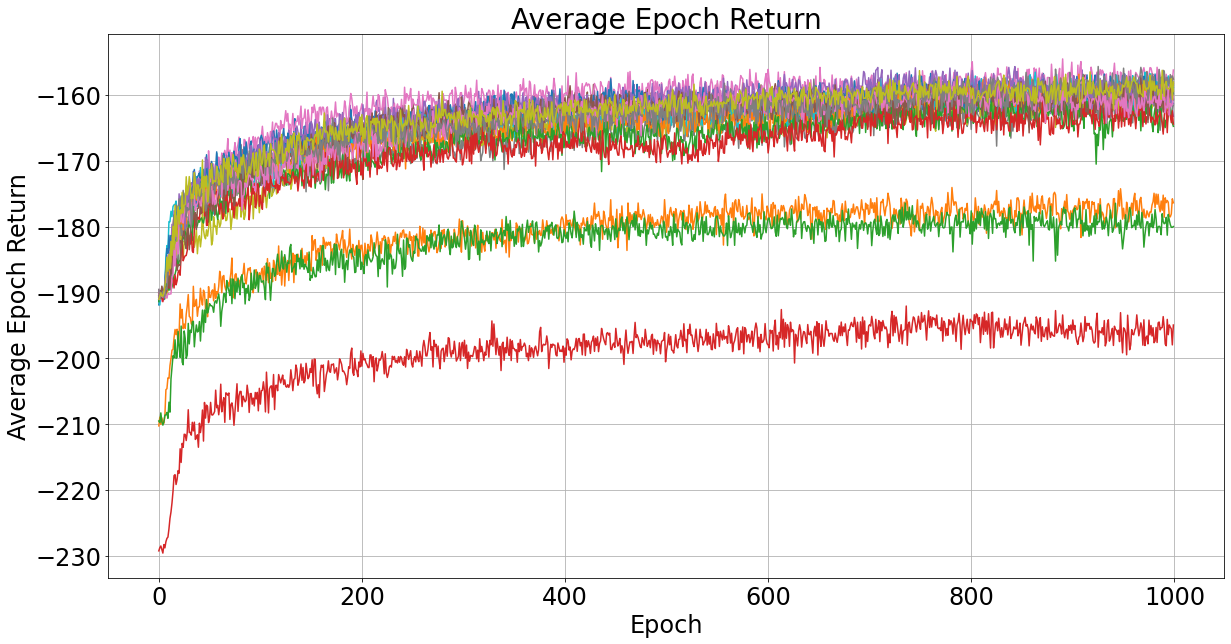

In [4]:
plt.figure(figsize=(20,10))
plt.title('Average Epoch Return',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Epoch Return',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

agent_paths = ['iter0_base','iter0_reward01','iter0_reward02','iter0_reward03',
              'iter0_rs01','iter0_rs02','iter0_gamma01','iter0_gamma02',
              'iter0_polyak01','iter0_polyak02','iter0_polyak03','iter0_lr01','iter0_lr02',
              'iter0_bs01','iter0_bs02','iter0_ss01','iter0_ss02','iter0_noise01','iter0_noise02']

for agent_path in agent_paths:
    progress = read_progress(agent_path)
#     print(agent_path, len(progress))
    plt.plot(np.arange(progress.shape[0]), progress[:,1])
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,3], progress[:,4], alpha=0.5)
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,1]+progress[:,2], progress[:,1]-progress[:,2], alpha=0.5)

# plt.xlim([0,500])
# plt.ylim([-2000,0])
# plt.legend(agent_paths,fontsize=24)

## Test an agent

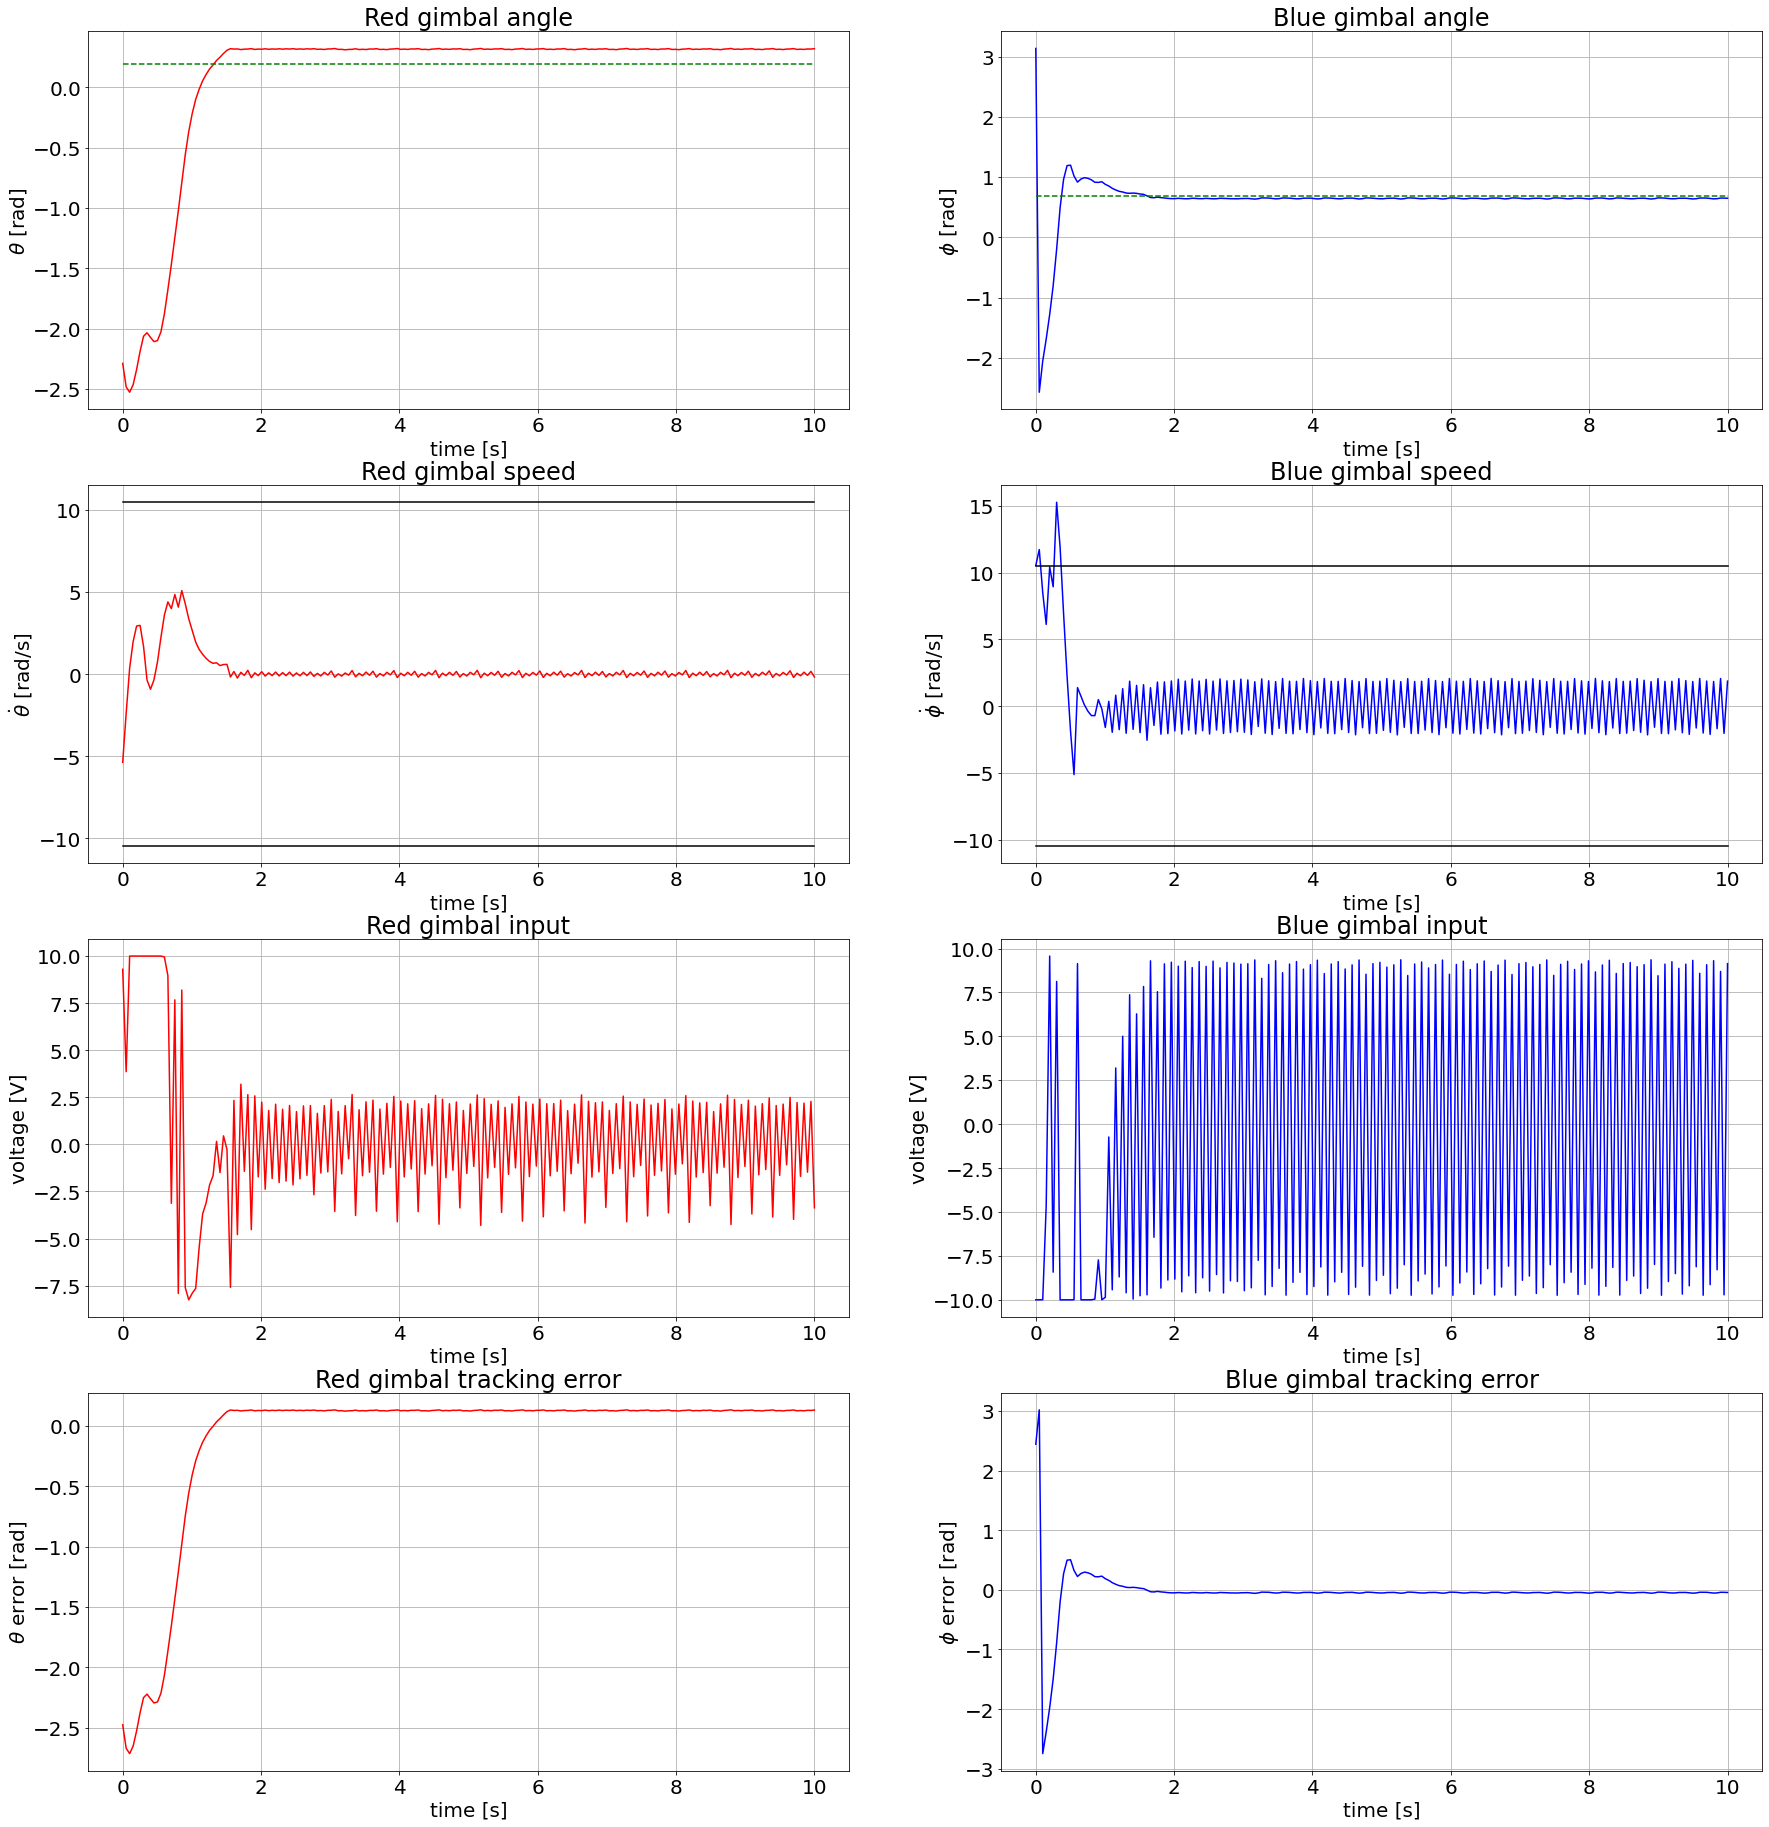

In [20]:
# Test paramaters
env_name = 'GyroscopeEnv-v1'

# init_state = np.array([0,0,0,0,200/60*2*np.pi,45/180*np.pi,-60/180*np.pi])
env = create_env(env_name,state=None)

agent_paths = ['iter0_base','iter0_reward01','iter0_reward02','iter0_reward03',
              'iter0_rs01','iter0_rs02','iter0_gamma01','iter0_gamma02',
              'iter0_polyak01','iter0_polyak02','iter0_polyak03','iter0_lr01','iter0_lr02',
              'iter0_bs01','iter0_bs02','iter0_ss01','iter0_ss02','iter0_noise01','iter0_noise02']

agent = load_agent(agent_paths[4])
t_end = 10

score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)
plot_test(state_record, action_record, t_end, 4)

## Evaluate control performance

In [5]:
iter0_metrics = pd.read_csv('iter0_metrics.csv')
pd.set_option('display.max_columns', None)
iter0_metrics

,Unnamed: 0,iter0_base,iter0_reward01,iter0_reward02,iter0_reward03,iter0_rs01,iter0_rs02,iter0_gamma01,iter0_gamma02,iter0_polyak01,iter0_polyak02,iter0_polyak03,iter0_lr01,iter0_lr02,iter0_bs01,iter0_bs02,iter0_ss01,iter0_ss02,iter0_noise01,iter0_noise02
0,$\theta$ MAE (rad),0.1234,0.1482,0.1435,0.1387,0.1413,0.1086,0.1124,0.1294,0.1330,0.1133,0.1104,0.1194,0.1616,0.1854,0.1240,0.1192,0.1150,0.1306,0.0980
1,$\phi$ MAE (rad),0.0851,0.0900,0.0963,0.1068,0.0806,0.0855,0.0794,0.1251,0.0837,0.0758,0.0825,0.0773,0.1033,0.1020,0.0801,0.0788,0.0906,0.0708,0.0743
2,$\theta$ MSSE (rad),0.0443,0.0538,0.0639,0.0503,0.0528,0.0255,0.0242,0.0460,0.0515,0.0325,0.0327,0.0368,0.0624,0.0809,0.0449,0.0377,0.0329,0.0430,0.0207
3,$\phi$ MSSE (rad),0.0257,0.0317,0.0302,0.0480,0.0269,0.0332,0.0235,0.0584,0.0214,0.0198,0.0254,0.0225,0.0382,0.0404,0.0255,0.0265,0.0334,0.0146,0.0149
4,$\theta$ in bounds (%),99.1600,93.8800,95.6300,98.1000,93.5000,99.9200,99.2900,97.2300,98.9100,98.7200,98.5400,99.4400,95.9400,94.9500,96.5200,99.2100,97.7900,97.8400,99.7300
5,$\phi$ in bounds (%),97.8200,95.6100,97.5400,99.4000,96.7500,95.4300,98.8100,89.3300,98.7800,99.5100,96.1600,98.6900,98.9800,88.4900,98.2300,99.2000,90.4000,96.9600,95.3200
6,$\theta$ unsteady (%),0.1400,2.5700,0.7100,0.4900,5.0000,0.0100,0.1700,0.4300,0.3000,0.7300,0.1100,0.0800,0.7000,1.5400,0.1400,0.3300,1.8000,0.2800,0.1400
7,$\phi$ unsteady (%),2.0600,3.8100,1.9300,0.4400,3.2200,4.3900,0.8600,9.5500,1.1300,0.4000,3.6600,1.1700,1.0100,8.5800,1.7100,0.5500,9.4200,3.0300,4.6400
8,$\theta$ rise time (s),0.5021,0.5363,0.5065,0.5484,0.5416,0.5078,0.4963,0.4743,0.4935,0.5054,0.4746,0.4957,0.5425,0.5597,0.4750,0.4945,0.4754,0.4929,0.4773
9,$\phi$ rise time (s),0.3080,0.3266,0.3218,0.3366,0.2958,0.3169,0.3031,0.3467,0.3100,0.3091,0.3226,0.3164,0.3162,0.2931,0.3191,0.3107,0.3240,0.3240,0.3109


In [6]:
# metrics = pd.read_csv(agent_paths[0]+'_metrics.csv')
# for ap in agent_paths[1:]:
#     m = pd.read_csv(ap+'_metrics.csv')
#     metrics = pd.concat([metrics, m.iloc[:,1:]], axis=1)
# metrics = metrics.round(4)
# metrics.to_csv('iter0_metrics.csv',index=False)